In [1]:
%cd /om/user/xboix/src/adversarial/Robustness

/om/user/xboix/src/adversarial/Robustness


In [2]:
experiment_name = "synthetic"
results_dir = '/vast/robustness/' + experiment_name + '/'

In [3]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.set_context("poster")

import matplotlib.pyplot as plt
import pandas as pd
import pickle 

import numpy as np

import runs.config_experiments_synthetic as run
experiment_list = run.config_experiments(results_dir, create_json=False)

855 config files created


In [4]:
name_attacks = ["linf_pgd","l2_pgd", "linf_fgsm", "l2_fgm"]

In [46]:
# Hash table of parameters
parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
              "robust_training": {}, "epsilon_pgd_training":{}}

to_exclude = [1]
experiment_list_tmp = [element for i, element in enumerate(experiment_list[90:135]) if i not in to_exclude]
for exp in experiment_list_tmp:
    for kk in parameters.keys():
        if exp[kk] in parameters[kk]:
            parameters[kk][exp[kk]].append(int(exp["model_name"]))
        else:
            parameters[kk][exp[kk]] = [int(exp["model_name"])]

for kk in parameters.keys():
    print(kk)
    print(list(parameters[kk].keys()))

epsilon
[0.1, 0.001, 0.01, 1]
backbone
['MLP', 'MLP+pgd']
initial_learning_rate
[0.1, 0.001, 0.0001, 1e-05, 0.01]
robust_training
[False, True]
epsilon_pgd_training
[0.1, 0.001, 0.01, 1]


[131, 115, 119, 123, 127]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


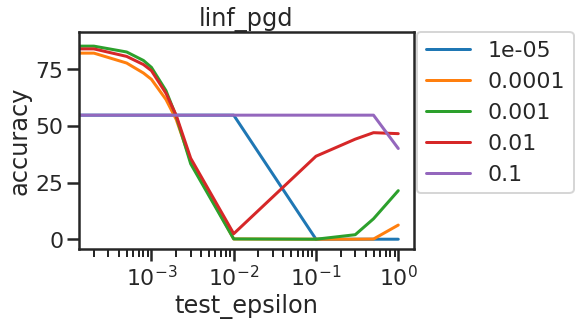

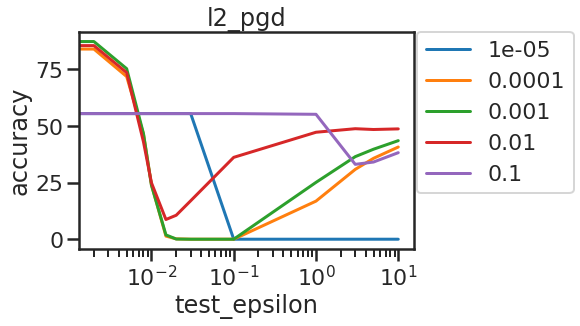

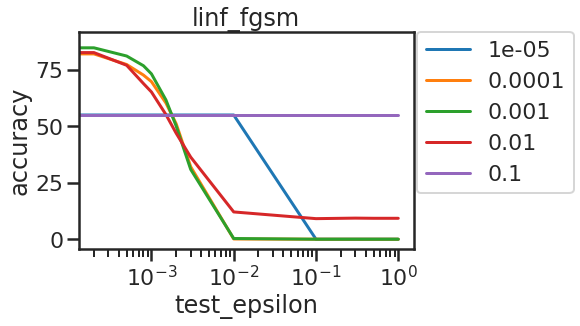

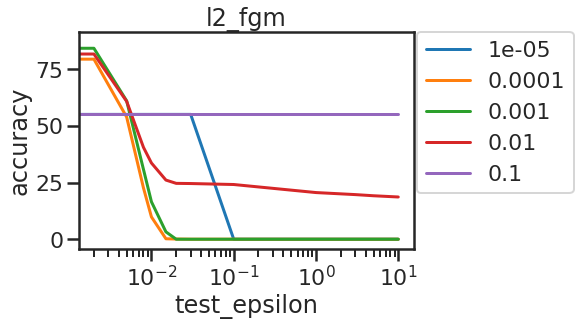

In [47]:
# Display learning rate impact
epsilon = 0.001
backbone = 'MLP+pgd'
robust_training = False
epsilon_pgd_training = 0.001

if robust_training:
    ids = list(set(parameters["backbone"][backbone]) & set(parameters["epsilon"][epsilon]) &
               set(parameters["robust_training"][robust_training]) 
               & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
else:
    ids = list(set(parameters["backbone"][backbone]) &
            set(parameters["robust_training"][robust_training]) & 
               set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))

print(ids)
list_entries = []
for id in ids:
    entry = {"learning_rate": experiment_list[id]['initial_learning_rate'],
            "backbone": experiment_list[id]['backbone'],
            "robust_training": experiment_list[id]['robust_training'],
            "epsilon": experiment_list[id]['epsilon']}
 
    for dataset in ["val", "test"]:
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)
            
            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 
for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="learning_rate",  palette="tab10",
                 data=df[df.dataset=='test'][df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


29
29
29
29


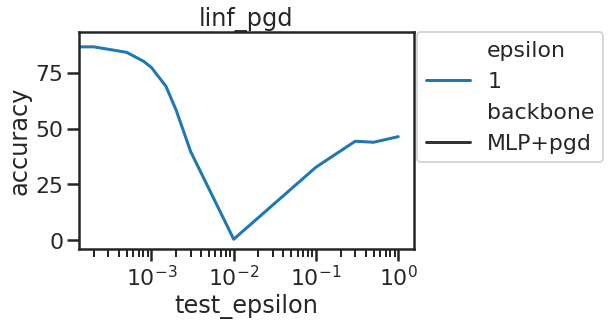

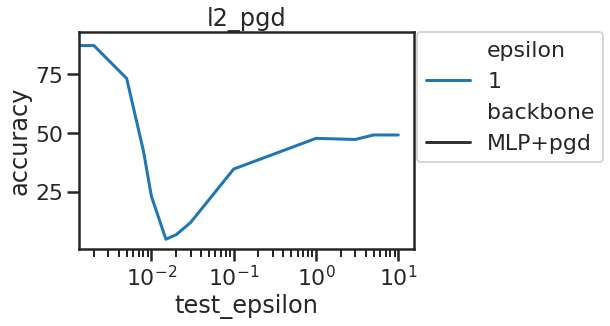

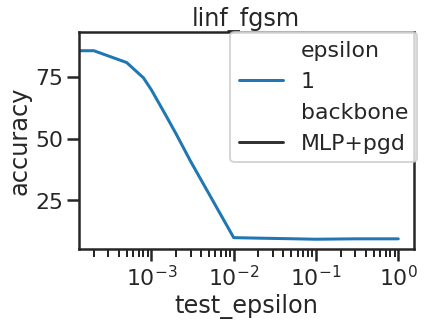

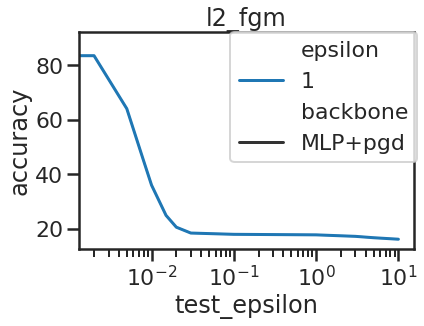

In [42]:
# Display epsilon
backbones = ['MLP+pgd']
robust_training = False
epsilon_pgd_training = 1e-3

list_entries = []
for backbone in backbones:
    for epsilon in list(parameters["epsilon"].keys()):

            
        if robust_training:
            ids = list(set(parameters["backbone"][backbone]) & set(parameters["epsilon"][epsilon]) &
                       set(parameters["robust_training"][robust_training])
                      & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
        else:
            ids = list(set(parameters["backbone"][backbone]) &
                    set(parameters["robust_training"][robust_training])
                      & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
            
        if len(ids)==0:
            continue
            
        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            acc = 0.0
            for attack in name_attacks:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in list(tmp.keys())[:2]:
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc
                
        print(best_id)
        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)

            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 

for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="epsilon",  style='backbone', palette="tab10",
                 data=df[df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


[96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 95]
99
[90, 92, 93, 94]
92
[128, 129, 130, 131, 132, 133, 134, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
119


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


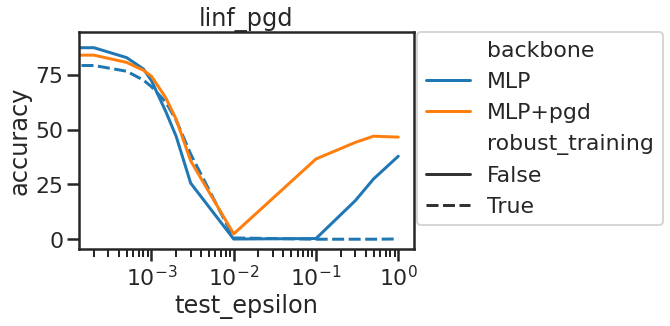

<Figure size 432x288 with 0 Axes>

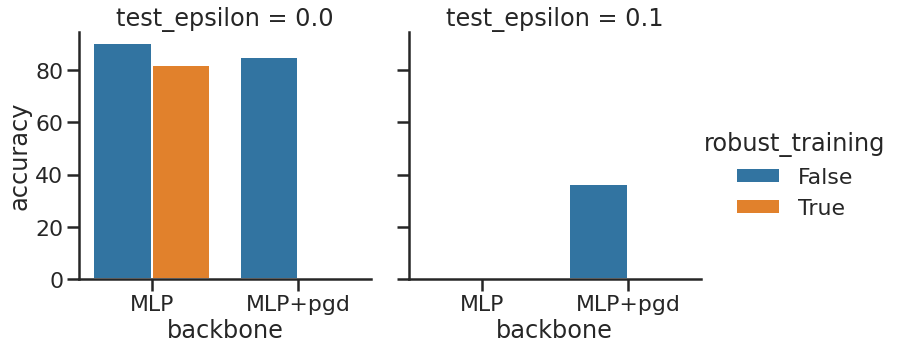

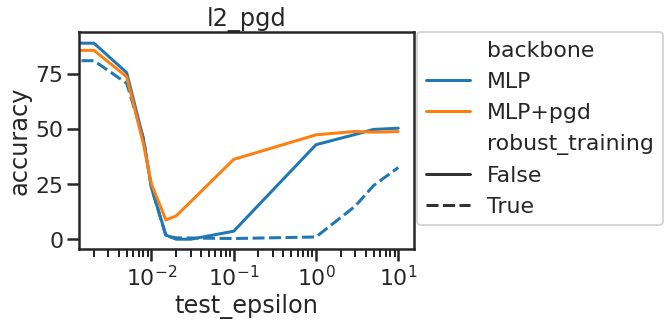

<Figure size 432x288 with 0 Axes>

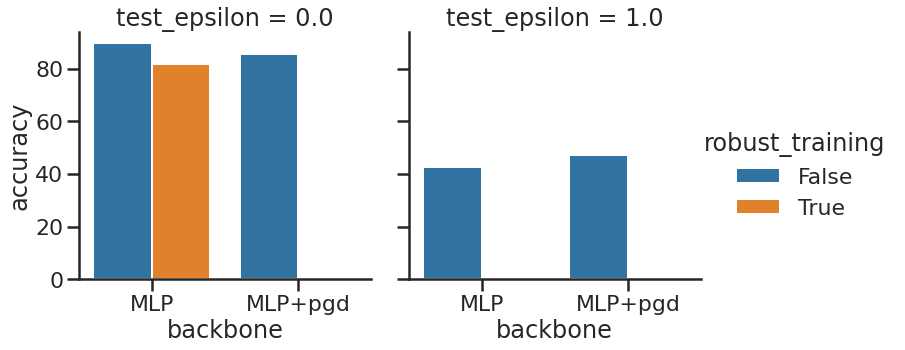

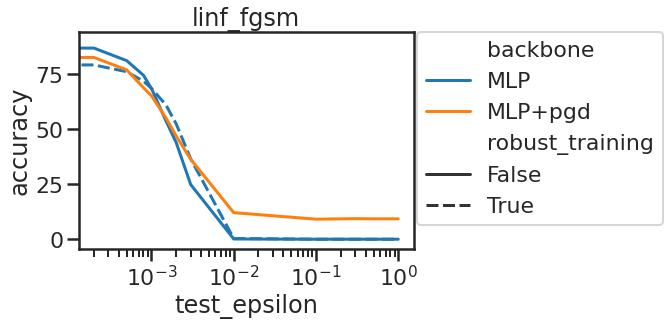

<Figure size 432x288 with 0 Axes>

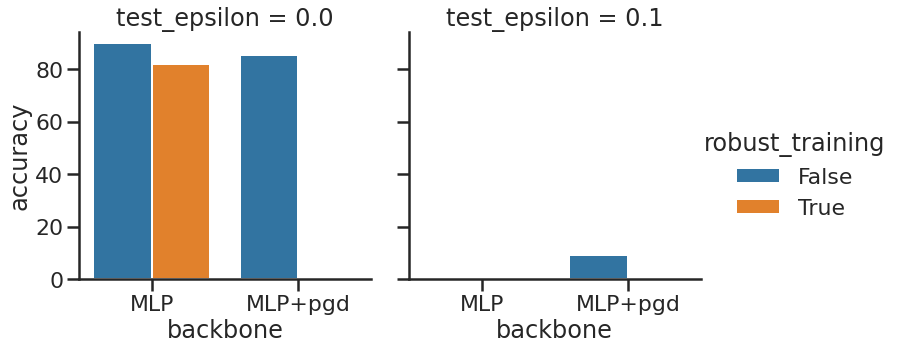

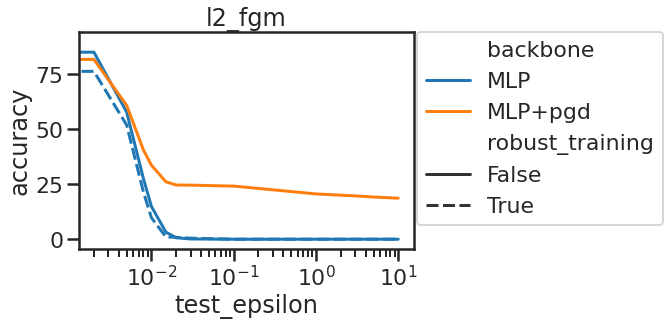

<Figure size 432x288 with 0 Axes>

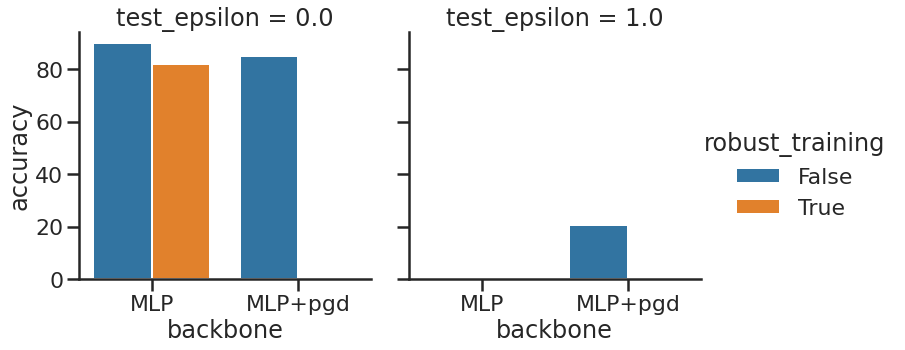

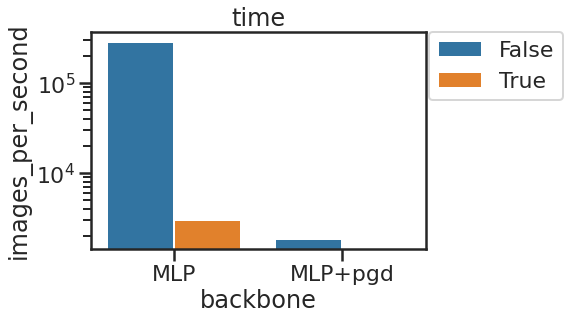

In [48]:
# Display best
backbones = ['MLP', 'MLP+pgd']
robust_trainings = [True,False]

list_entries = []
for backbone in backbones:
    for robust_training in robust_trainings:
        if (backbone == 'Madry' and robust_training == True) or \
            (backbone == 'CNN+clipping' and robust_training == False):
            continue
            
        ids = list(set(parameters["backbone"][backbone]) & set(parameters["robust_training"][robust_training]))
        
        if ids == []:
            continue
        print(ids)
        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            #if (experiment_list[id]['backbone'] == 'CNN+pgd') and experiment_list[id]["epsilon_pgd_training"] == 0.3:
            #    continue 
            acc = 0.0
            for attack in [name_attacks[0]]:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in list(tmp.keys())[:2]:
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc

        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        print(best_id)
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)

            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
            
            if not backbone == 'Madry':
                with open(results_dir + experiment_list[best_id]['model_name'] + 
                          '/results/training_time.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                entry["images_per_second"] = np.mean(tmp) 
                entry["std_images_per_second"] = np.std(tmp) 
                
df = pd.DataFrame.from_dict(list_entries) 

for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="backbone",  style='robust_training', palette="tab10",
                 data=df[df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

    plt.figure()
    epsilon = 0.1
    if attack == "l2_pgd" or attack == "l2_fgm" :
        epsilon = 1
    sns.catplot(x="backbone", y="accuracy",
                 hue="robust_training", col="test_epsilon", palette="tab10",kind="bar",
                 data=df[(df.test_epsilon == 0)| (df.test_epsilon == epsilon)][df.attack==attack])
    #plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

plt.figure()
sns.barplot(x="backbone", y="images_per_second",
             hue="robust_training", palette="tab10",
             data=df).set_title("time")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

In [42]:
experiment_list[241]

{'_comment': '=====ADVERSARIAL EXAMPLES CONFIGURATION=====',
 'model_name': '241',
 'restart': False,
 'data_set': 'mnist',
 'num_classes': 10,
 'backbone': 'CNN+pgd',
 'l1_size': 200,
 'l2_size': 200,
 'random_seed': 4557077,
 'robust_training': True,
 'max_num_training_steps': 10000,
 'num_output_steps': 500,
 'training_size': 50000,
 'validation_size': 1000,
 'testing_size': 10000,
 'training_batch_size': 256,
 'initial_learning_rate': 0.001,
 'batch_decrease_learning_rate': 5,
 'eval_attack_during_training': True,
 'epsilon': 0.05,
 'increasing_epsilon': False,
 'pgd_training': True,
 'epsilon_pgd_training': 0.3}

In [87]:
df[df.backbone=="Madry"][df.attack=="linf_pgd"][df.test_epsilon == 0.3 ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy,images_per_second,std_images_per_second
218,0.001,Madry,True,0.1,test,linf_pgd,0.3,93.515625,NaN,NaN
270,0.001,Madry,True,0.1,test,linf_pgd,0.3,93.515625,NaN,NaN


In [107]:
df[df.backbone=="Madry"][df.attack=="linf_fgsm"][df.test_epsilon == 0.3 ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy,images_per_second,std_images_per_second
244,0.001,Madry,True,0.1,test,linf_fgsm,0.3,95.507812,NaN,NaN
296,0.001,Madry,True,0.1,test,linf_fgsm,0.3,95.507812,NaN,NaN
